In [1]:
import sys
sys.path.append("../../utilities/")
from binned_bedgraph import bin_bedgraph_file
import data_utils
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pybedtools

In [2]:
# fc file link: https://egg2.wustl.edu/roadmap/data/byFileType/signal/consolidated/macs2signal/foldChange/E116-H2A.Z.fc.signal.bigwig
# pval file link: https://egg2.wustl.edu/roadmap/data/byFileType/signal/consolidated/macs2signal/pval/E116-H2A.Z.pval.signal.bigwig
# broad-peaks file link: https://egg2.wustl.edu/roadmap/data/byFileType/peaks/consolidated/broadPeak/E116-H2A.Z.broadPeak.gz
fc_infile = "fc.bedgraph"
fc_outfile = "binned_fc.bedgraph"
bin_bedgraph_file(fc_infile, 100000, fc_outfile, False)
pval_infile = "pval.bedgraph"
pval_outfile = "binned_pval.bedgraph"
bin_bedgraph_file(pval_infile, 100000, pval_outfile, False)

In [137]:
binned_fc_df = pd.read_csv('binned_fc.bedgraph', sep = "\t", header = None)
binned_fc_df.columns = ['chr_name', 'start', 'end', 'fc']
binned_pval_df = pd.read_csv('binned_pval.bedgraph', sep = "\t", header = None)
binned_pval_df.columns = ['chr_name', 'start', 'end', 'pval']

In [134]:
chrom_size = data_utils.hg19_chr_sizes['chr1']
start_pos = np.arange(0,chrom_size,100000)
binned_df = pd.DataFrame({'chr_name': 'chr1', 'start_pos': start_pos, 'end_pos': start_pos+100000})
binned_bed = pybedtools.BedTool.from_dataframe(binned_df)
peaks_df = pd.read_csv("broad-peak", sep = "\t", header = None)
peaks_bed = pybedtools.BedTool("broad-peak")
peaks_bed = peaks_bed.sort()
dist_count_peaks = pybedtools.bedtool.BedTool.map(binned_bed, peaks_bed, c = 5, o = 'count_distinct')
dist_count_peaks = dist_count_peaks.to_dataframe()
dist_count_peaks.columns = ['chr_name', 'start', 'end', 'dist_count_peaks']

In [138]:
df = pd.merge(binned_fc_df,binned_pval_df,on=['chr_name','start','end'], how = 'inner')
df = pd.merge(df,dist_count_peaks,on=['chr_name','start','end'], how = 'inner')

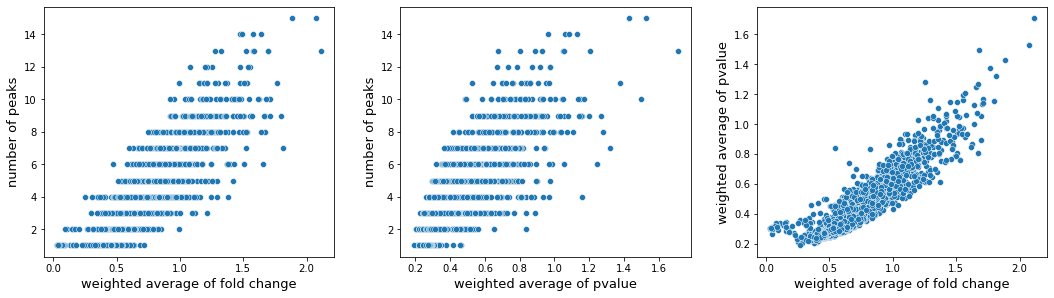

In [150]:
fig, axs = plt.subplots(1, 3, figsize=(15,4.5))
sns.scatterplot(data = df[df['dist_count_peaks']!=0], x = 'fc', y = 'dist_count_peaks', ax = axs[0])
axs[0].set_xlabel('weighted average of fold change', size = 13)
axs[0].set_ylabel('number of peaks', size = 13)

sns.scatterplot(data = df[df['dist_count_peaks']!=0], x = 'pval', y = 'dist_count_peaks', ax = axs[1])
axs[1].set_xlabel('weighted average of pvalue', size = 13)
axs[1].set_ylabel('number of peaks', size = 13)

sns.scatterplot(data = df[df['dist_count_peaks']!=0], x = 'fc', y = 'pval', ax = axs[2])
axs[2].set_xlabel('weighted average of fold change', size = 13)
axs[2].set_ylabel('weighted average of pvalue', size = 13)

fig.tight_layout(pad=2.0)
fig.savefig("input_types_comparison.png", 
            format="png", dpi=144, bbox_inches="tight", pad_inches=0.2, facecolor='white', transparent=False)